# Part 2: Stepping up our game

This notebook is designed to accompany this blog post https://datasciencecastnet.home.blog/2019/10/21/zindi-uberct-part-2-stepping-up/.

It will take you through adding some extra features, creating a deep learning model with fastai and making a submission.

# Load data

Upload the train.csv and road_segments.zip files from Zindi, as well as the weather.csv file described in the blog post (or available for download here ADD LINK)

In [52]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [53]:
from sklearn.metrics import log_loss, f1_score

In [54]:
data = pd.read_csv('train.csv', 
                   parse_dates = ['Occurrence Local Date Time'])
data.head()

EventId Occurrence Local Date Time Reporting Agency               Cause  \
0    60558        2016-01-01 00:53:00              Cam  Stationary Vehicle   
1    60559        2016-01-01 00:54:00           CAMERA            Accident   
2    60560        2016-01-01 02:26:00  Law Enforcement            Accident   
3    60561        2016-01-01 02:56:00           CAMERA  Stationary Vehicle   
4    60562        2016-01-01 03:40:00           CAMERA            Accident   

              Subcause  Status      longitude   latitude road_segment_id  
0  Vehicle On Shoulder  Closed  18.5408955032 -33.888275         S0B3CGQ  
1  With A Fixed Object  Closed  18.9307563219 -34.140857         RYJYAPI  
2        Multi Vehicle  Closed  18.5533575029 -33.959154         U3KP57C  
3  Vehicle On Shoulder  Closed  18.6775561589 -33.895258         RY0TRQ8  
4        Multi Vehicle  Closed  18.8371319682 -34.087051         8LOVJZ3

In [55]:
data.tail()

EventId Occurrence Local Date Time Reporting Agency  \
53840   152136        2018-12-31 21:14:00           Camera   
53841   152139        2018-12-31 21:33:00           Camera   
53842   152142        2018-12-31 22:01:00             SAPS   
53843   152143        2018-12-31 22:12:00           Camera   
53844   152149        2018-12-31 23:45:00             SAPS   

                     Cause       Subcause  Status      longitude   latitude  \
53840   Stationary Vehicle  Shoulder Lane  Closed   18.601735312 -33.989120   
53841   Stationary Vehicle  Shoulder Lane  Closed  18.5765946661 -33.970978   
53842  Police and Military      Hijacking  Closed  18.6585756463 -33.949194   
53843   Stationary Vehicle  Shoulder Lane  Closed  18.6250798029 -33.888283   
53844   Stationary Vehicle  Shoulder Lane  Closed  18.6529483529 -33.976858   

      road_segment_id  
53840         CZBWW0Z  
53841         7AKUBY4  
53842         YQCBO2Y  
53843         Z2OSI9E  
53844         GFX7S4B

I'm splitting it up into train and test sets for local testing. When ready, re-do the steps training with all data and make predictions for the dates covered by Zindi's sample submission.

In [56]:
# Train on 2017
train = data.loc[data['Occurrence Local Date Time'] < '2018-04-01']

# Test locally on the last part of 2018
test = data.loc[data['Occurrence Local Date Time'] < '2019-01-01']
test = test.loc[test['Occurrence Local Date Time'] >= '2018-09-01']

In [57]:
# Create a dataframe with a column for each segment_id (sid)
# Each row represents an hour.

sids = data['road_segment_id'].unique()

## <<<<<<<<<<<<<<<<<<<< Added dates, excluding missing data
p1 = pd.date_range('2016-01-01',
                    '2016-07-01',
                    freq="1h")
p2 = pd.date_range('2016-09-01',
                    '2018-04-01',
                    freq="1h")
dts = p1.union(p2)

tr = pd.DataFrame({'datetime':dts})

for sid in sids:
    tr[str(sid)] = 0
    events = train.loc[train['road_segment_id'] == sid]
    dts = events['Occurrence Local Date Time'].dt.round('H')
    dates = dts.astype(str).unique()
    tr.loc[tr['datetime'].isin(dates), sid] = 1
tr.head()

datetime  S0B3CGQ  RYJYAPI  U3KP57C  RY0TRQ8  8LOVJZ3  X4UA382  \
0 2016-01-01 00:00:00        0        0        0        0        0        0   
1 2016-01-01 01:00:00        1        1        0        0        0        0   
2 2016-01-01 02:00:00        0        0        1        0        0        0   
3 2016-01-01 03:00:00        0        0        0        1        0        0   
4 2016-01-01 04:00:00        0        0        0        0        1        0   

   0QR8FDW  DZABHQW  EKZN1VM  ...  YVR8GT6  ZAVM3PJ  DS4NLQE  HR19LL7  \
0        0        0        0  ...        0        0        0        0   
1        0        0        0  ...        0        0        0        0   
2        0        0        0  ...        0        0        0        0   
3        0        0        0  ...        0        0        0        0   
4        0        0        0  ...        0        0        0        0   

   1451FOG  2ON8NSO  NFUEAN5  4T821GV  J6A19TW  43RCYZH  
0        0        0        0        0        0        0  
1        0        0        0        0        0        0  
2        0        0        0        0        0        0  
3        0        0        0        0        0        0  
4        0        0        0        0        0        0  

[5 rows x 550 columns]

In [58]:
# Reshape this as in sample submission
# I add some extra columns that may be useful
train = pd.DataFrame({
    'datetime x segment_id':np.concatenate([[str(x) + " x " + str(c) 
                                             for c in sids] 
                                            for x in tr['datetime']]),
    'datetime':np.concatenate([[str(x) for c in sids] for x in tr['datetime']]),
    'segment_id':np.concatenate([[str(c) for c in sids] for x in tr['datetime']]),
    'y':tr[sids].values.flatten()
})
train.head()

datetime x segment_id             datetime segment_id  y
0  2016-01-01 00:00:00 x S0B3CGQ  2016-01-01 00:00:00    S0B3CGQ  0
1  2016-01-01 00:00:00 x RYJYAPI  2016-01-01 00:00:00    RYJYAPI  0
2  2016-01-01 00:00:00 x U3KP57C  2016-01-01 00:00:00    U3KP57C  0
3  2016-01-01 00:00:00 x RY0TRQ8  2016-01-01 00:00:00    RY0TRQ8  0
4  2016-01-01 00:00:00 x 8LOVJZ3  2016-01-01 00:00:00    8LOVJZ3  0

In [59]:
# Same for test 
dts = pd.date_range('2018-09-01','2018-12-31',
                    freq="1h")
tr = pd.DataFrame({'datetime':dts})

for sid in sids:
    tr[str(sid)] = 0
    events = test.loc[test['road_segment_id'] == sid]
    dts = events['Occurrence Local Date Time'].dt.round('H')
    dates = dts.astype(str).unique()
    tr.loc[tr['datetime'].isin(dates), sid] = 1
    
test = pd.DataFrame({
    'datetime x segment_id':np.concatenate([[str(x) + " x " + str(c) 
                                             for c in sids] 
                                            for x in tr['datetime']]),
    'datetime':np.concatenate([[str(x) for c in sids] for x in tr['datetime']]),
    'segment_id':np.concatenate([[str(c) for c in sids] for x in tr['datetime']]),
    'y':tr[sids].values.flatten()
})
test.head()

datetime x segment_id             datetime segment_id  y
0  2018-09-01 00:00:00 x S0B3CGQ  2018-09-01 00:00:00    S0B3CGQ  0
1  2018-09-01 00:00:00 x RYJYAPI  2018-09-01 00:00:00    RYJYAPI  0
2  2018-09-01 00:00:00 x U3KP57C  2018-09-01 00:00:00    U3KP57C  0
3  2018-09-01 00:00:00 x RY0TRQ8  2018-09-01 00:00:00    RY0TRQ8  0
4  2018-09-01 00:00:00 x 8LOVJZ3  2018-09-01 00:00:00    8LOVJZ3  0

# Adding info from road_segments.shp

In [9]:
!pip install geopandas

In [10]:
!unzip road_segments.zip

unzip:  cannot find or open road_segments.zip, road_segments.zip.zip or road_segments.zip.ZIP.


ROADNO    CLASS        REGION  WIDTH  LANES SURFTYPE PAVETYPE CONDITION  \
0   R300  Primary  Western Cape   20.2      2    Paved     FLEX      Good   
1   R300  Primary  Western Cape   20.2      2    Paved     FLEX      Good   
2   R300  Primary  Western Cape   20.2      2    Paved     FLEX      Good   
3   R300  Primary  Western Cape   20.2      2    Paved     FLEX      Good   
4   R300  Primary  Western Cape   20.2      2    Paved     FLEX      Good   

   length_1 segment_id                                           geometry  
0   471.207    D1U6OOF  LINESTRING (18.65262 -33.97724, 18.65264 -33.9...  
1   471.207    NG4X2MD  LINESTRING (18.65347 -33.97309, 18.65347 -33.9...  
2   471.207    792705Z  LINESTRING (18.65431 -33.96894, 18.65432 -33.9...  
3   471.207    IK67XHB  LINESTRING (18.65515 -33.96480, 18.65517 -33.9...  
4   471.207    OWCF2MH  LINESTRING (18.65600 -33.96065, 18.65602 -33.9...

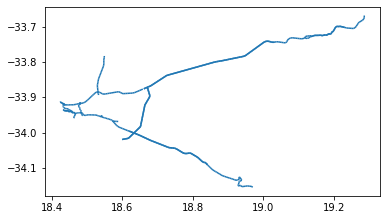

In [60]:
import geopandas as gpd
road_segments = gpd.read_file('road_segments/road_segments.shp')
road_segments.geometry.plot()
road_segments.head()

# Getting locations of each segment

In [12]:
locations = data.groupby('road_segment_id').mean()[['latitude']]
locations.head(2)

latitude
road_segment_id           
-33.8891283413   18.614566
-33.9622761744   18.564216

# Adding weather

In [13]:
w = pd.read_csv('weather.csv', sep=";", skiprows=6, usecols=range(14),
               parse_dates=['Local time in Cape Town (airport)'])
w.head()

Local time in Cape Town (airport)     T     P0      P     U  \
0               2019-04-04 23:00:00  15.0  762.0  765.8  77.0   
1               2019-04-04 22:00:00  16.0  761.2  765.0  77.0   
2               2019-04-04 21:59:00  16.0  761.2  765.0  77.0   
3               2019-04-04 21:01:00  15.0  761.2  765.0  94.0   
4               2019-04-04 21:00:00  15.0  761.2  765.0  94.0   

                                      DD   Ff  ff10   WW W'W'  \
0  Wind blowing from the south-southeast  6.0   NaN  NaN  NaN   
1  Wind blowing from the south-southeast  6.0   NaN  NaN  NaN   
2  Wind blowing from the south-southeast  6.0   NaN  NaN  NaN   
3  Wind blowing from the south-southeast  6.0   NaN  NaN  NaN   
4  Wind blowing from the south-southeast  6.0   NaN  NaN  NaN   

                                                   c             VV    Td  \
0  Scattered clouds (40-50%) 720 m, broken clouds...  10.0 and more  11.0   
1  Scattered clouds (40-50%) 570 m, broken clouds...  10.0 and more  12.0   
2  Scattered clouds (40-50%) 570 m, broken clouds...  10.0 and more  12.0   
3  Scattered clouds (40-50%) 150 m, broken clouds...  10.0 and more  14.0   
4  Scattered clouds (40-50%) 150 m, broken clouds...  10.0 and more  14.0   

   Unnamed: 13  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [14]:
# Add weather
w['dt'] = w['Local time in Cape Town (airport)'].dt.round('H')
w_cols = ['dt', 'T', 'P0', 'P', 'U', 'Ff']

# Merge in the new data and add date vars etc

In [15]:
# Pre-process the train
train['datetime'] = pd.to_datetime(train['datetime'])
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.weekday_name
train['min'] = train['datetime'].dt.hour*60+train['datetime'].dt.minute
train = pd.merge(train, road_segments, on='segment_id', how='left') # Segment info
train = pd.merge(train, locations, left_on='segment_id', right_on='road_segment_id', how='left') # Segment locations
train = pd.merge(train, w[w_cols], left_on='datetime', right_on='dt', how='left') # Weather

# Pre-process the test to match train
test['datetime'] = pd.to_datetime(test['datetime'])
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.weekday_name
test['min'] = test['datetime'].dt.hour*60+test['datetime'].dt.minute
test = pd.merge(test, road_segments, on='segment_id', how='left')
test = pd.merge(test, locations, left_on='segment_id', right_on='road_segment_id', how='left')
test = pd.merge(test, w[w_cols], left_on='datetime', right_on='dt', how='left')

train.head()

datetime x segment_id   datetime segment_id  y  month     day  min  \
0  2016-01-01 00:00:00 x S0B3CGQ 2016-01-01    S0B3CGQ  0      1  Friday    0   
1  2016-01-01 00:00:00 x RYJYAPI 2016-01-01    RYJYAPI  0      1  Friday    0   
2  2016-01-01 00:00:00 x U3KP57C 2016-01-01    U3KP57C  0      1  Friday    0   
3  2016-01-01 00:00:00 x RY0TRQ8 2016-01-01    RY0TRQ8  0      1  Friday    0   
4  2016-01-01 00:00:00 x 8LOVJZ3 2016-01-01    8LOVJZ3  0      1  Friday    0   

  ROADNO    CLASS        REGION  ...  CONDITION  length_1  \
0     N1  Primary  Western Cape  ...    Unknown   521.765   
1     N2  Primary  Western Cape  ...  Very Good   521.945   
2     N2  Primary  Western Cape  ...    Unknown   452.679   
3   R300  Primary  Western Cape  ...       Fair   493.974   
4     N2  Primary  Western Cape  ...  Very Good   569.263   

                                            geometry   latitude         dt  \
0  LINESTRING (18.54354 -33.89011, 18.54268 -33.8... -33.888613 2016-01-01   
1  LINESTRING (18.93214 -34.13857, 18.93208 -34.1... -34.139930 2016-01-01   
2  LINESTRING (18.55332 -33.95934, 18.54963 -33.9... -33.958279 2016-01-01   
3  LINESTRING (18.67690 -33.89936, 18.67691 -33.8... -33.896611 2016-01-01   
4  LINESTRING (18.83297 -34.08474, 18.83303 -34.0... -34.086109 2016-01-01   

      T     P0      P     U   Ff  
0  22.0  756.0  759.7  83.0  5.0  
1  22.0  756.0  759.7  83.0  5.0  
2  22.0  756.0  759.7  83.0  5.0  
3  22.0  756.0  759.7  83.0  5.0  
4  22.0  756.0  759.7  83.0  5.0  

[5 rows x 24 columns]

In [16]:
train.shape

(10842750, 24)

In [17]:
test.shape

(1776015, 24)

# Create an equivalent dataset for submission

In [18]:
# Make the dataframe - dates based on sample submission file
dts = pd.date_range('2019-01-01 01:00:00',
                    '2019-03-31 23:00:00',
                    freq="1h")
tr = pd.DataFrame({'datetime':dts})

for sid in sids:
    tr[str(sid)] = 0
    
ss = pd.DataFrame({
    'datetime x segment_id':np.concatenate([[str(x) + " x " + str(c)  
                                            for x in tr['datetime']for c in sids]]),
    'datetime':np.concatenate([[str(x) for x in tr['datetime']for c in sids]]),
    'segment_id':np.concatenate([[str(c) for x in tr['datetime']for c in sids]])
})
ss.head()

datetime x segment_id             datetime segment_id
0  2019-01-01 01:00:00 x S0B3CGQ  2019-01-01 01:00:00    S0B3CGQ
1  2019-01-01 01:00:00 x RYJYAPI  2019-01-01 01:00:00    RYJYAPI
2  2019-01-01 01:00:00 x U3KP57C  2019-01-01 01:00:00    U3KP57C
3  2019-01-01 01:00:00 x RY0TRQ8  2019-01-01 01:00:00    RY0TRQ8
4  2019-01-01 01:00:00 x 8LOVJZ3  2019-01-01 01:00:00    8LOVJZ3

In [19]:
# Add the extra features
ss['datetime'] = pd.to_datetime(ss['datetime'])
ss['day'] = ss['datetime'].dt.weekday_name
ss['month'] = ss['datetime'].dt.month
ss['min'] = ss['datetime'].dt.hour*60+ss['datetime'].dt.minute
ss = pd.merge(ss, road_segments, on='segment_id', how='left')
ss = pd.merge(ss, locations, left_on='segment_id', right_on='road_segment_id', how='left')
ss = pd.merge(ss, w[w_cols], left_on='datetime', right_on='dt', how='left')
ss['prediction'] = 0
ss.head()

datetime x segment_id            datetime segment_id      day  \
0  2019-01-01 01:00:00 x S0B3CGQ 2019-01-01 01:00:00    S0B3CGQ  Tuesday   
1  2019-01-01 01:00:00 x RYJYAPI 2019-01-01 01:00:00    RYJYAPI  Tuesday   
2  2019-01-01 01:00:00 x U3KP57C 2019-01-01 01:00:00    U3KP57C  Tuesday   
3  2019-01-01 01:00:00 x RY0TRQ8 2019-01-01 01:00:00    RY0TRQ8  Tuesday   
4  2019-01-01 01:00:00 x 8LOVJZ3 2019-01-01 01:00:00    8LOVJZ3  Tuesday   

   month  min ROADNO    CLASS        REGION  WIDTH  ...  length_1  \
0      1   60     N1  Primary  Western Cape    0.0  ...   521.765   
1      1   60     N2  Primary  Western Cape   12.8  ...   521.945   
2      1   60     N2  Primary  Western Cape    0.0  ...   452.679   
3      1   60   R300  Primary  Western Cape   20.2  ...   493.974   
4      1   60     N2  Primary  Western Cape   20.2  ...   569.263   

                                            geometry   latitude  \
0  LINESTRING (18.54354 -33.89011, 18.54268 -33.8... -33.888613   
1  LINESTRING (18.93214 -34.13857, 18.93208 -34.1... -34.139930   
2  LINESTRING (18.55332 -33.95934, 18.54963 -33.9... -33.958279   
3  LINESTRING (18.67690 -33.89936, 18.67691 -33.8... -33.896611   
4  LINESTRING (18.83297 -34.08474, 18.83303 -34.0... -34.086109   

                   dt     T     P0      P     U   Ff  prediction  
0 2019-01-01 01:00:00  19.0  756.8  760.5  88.0  5.0           0  
1 2019-01-01 01:00:00  19.0  756.8  760.5  88.0  5.0           0  
2 2019-01-01 01:00:00  19.0  756.8  760.5  88.0  5.0           0  
3 2019-01-01 01:00:00  19.0  756.8  760.5  88.0  5.0           0  
4 2019-01-01 01:00:00  19.0  756.8  760.5  88.0  5.0           0  

[5 rows x 24 columns]

In [20]:
ss.shape

(1308816, 24)

# Listing the columns we've created and will use for modelling

In [21]:
x_cols = ['day', 'segment_id', 'min', 'latitude', 'ROADNO', 'length_1',  'LANES', 'CONDITION', 'month', 'T', 'P0', 'P', 'U', 'Ff']
cat_cols = ['day', 'month', 'segment_id', 'ROADNO',  'LANES', 'CONDITION']

# Trying Fastai tabular

In [22]:
from fastai.tabular import *

In [23]:
dep_var = 'y'
cat_names = cat_cols
cont_names = [x for x in x_cols if x not in cat_cols]
procs = [FillMissing, Categorify, Normalize]

In [24]:
te = TabularList.from_df(test, cat_names=cat_names, cont_names=cont_names) # Change to ss after experimentation

In [25]:
data = (TabularList.from_df(train, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(int(train.shape[0]*0.9),train.shape[0])))
                           .label_from_df(cols=dep_var)
                           .add_test(te)
                           .databunch(bs=5000))

In [26]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


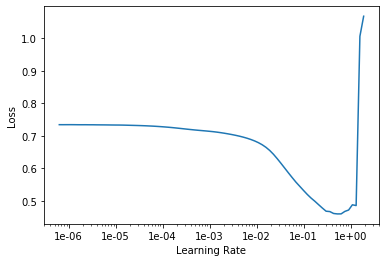

In [28]:
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(3, slice(3e-2))

In [30]:
predictions, *_ = learn.get_preds(DatasetType.Test)

# Tuning threshold to maximise F1 score:

In [31]:
test['p'] = predictions[:,1]
for t in [0.01, 0.03, 0.035, 0.04, 0.045, 0.05, 0.1, 0.3]:
  test['pt'] = (test['p']>t).astype(int)
  print('Threshold: ', t, 'F1:', f1_score(test['y'], test['pt']))

Threshold:  0.01 F1: 0.05665255867641401
Threshold:  0.03 F1: 0.08041573867854492
Threshold:  0.035 F1: 0.08240830549268958
Threshold:  0.04 F1: 0.08158292723911946
Threshold:  0.045 F1: 0.08092925830715034
Threshold:  0.05 F1: 0.0783015397551106
Threshold:  0.1 F1: 0.06126543209876543
Threshold:  0.3 F1: 0.018862363689949896


Refining more

In [32]:
for t in [0.01, 0.025, 0.027, 0.029, 0.031, 0.033, 0.035, 0.037]:
  test['pt'] = (test['p']>t).astype(int)
  print(t, f1_score(test['y'], test['pt']))

0.01 0.05665255867641401
0.025 0.07880998355145534
0.027 0.08004388829384258
0.029 0.08028261303096779
0.031 0.08123647604327666
0.033 0.08206189697192268
0.035 0.08240830549268958
0.037 0.08215917380120552


# Tuning, submission

So you can see we're getting an F1 score aroud 0.082 on our test set. For some reason I tend to score higher on Zindi! To turn this into a submission, you can use the submission dataset (ss) as the test set for the learner, and then threshold the predicted probabilities based on the top value found above and use that as you submission. Before you do that, I sugest you play around with training for longer, adding different features, tweaking things further..... go crazy :) If you have questions, feel free to get hold of me or, better, post them in the discussions on Zindi. Good luck.

In [35]:
# Make the dataframe - dates based on sample submission file
dts = pd.date_range('2019-01-01 01:00:00',
                    '2019-03-31 23:00:00',
                    freq="1h")
tr = pd.DataFrame({'datetime':dts})

for sid in sids:
    tr[str(sid)] = 0
    
ss = pd.DataFrame({
    'datetime x segment_id':np.concatenate([[str(x) + " x " + str(c)  
                                            for x in tr['datetime']for c in sids]]),
    'datetime':np.concatenate([[str(x) for x in tr['datetime']for c in sids]]),
    'segment_id':np.concatenate([[str(c) for x in tr['datetime']for c in sids]])
})
ss.head()

datetime x segment_id             datetime segment_id
0  2019-01-01 01:00:00 x S0B3CGQ  2019-01-01 01:00:00    S0B3CGQ
1  2019-01-01 01:00:00 x RYJYAPI  2019-01-01 01:00:00    RYJYAPI
2  2019-01-01 01:00:00 x U3KP57C  2019-01-01 01:00:00    U3KP57C
3  2019-01-01 01:00:00 x RY0TRQ8  2019-01-01 01:00:00    RY0TRQ8
4  2019-01-01 01:00:00 x 8LOVJZ3  2019-01-01 01:00:00    8LOVJZ3

In [36]:
# Add the extra features
ss['datetime'] = pd.to_datetime(ss['datetime'])
ss['day'] = ss['datetime'].dt.weekday_name
ss['min'] = ss['datetime'].dt.hour*60+ss['datetime'].dt.minute
ss = pd.merge(ss, locations, left_on='segment_id', right_on='road_segment_id', how='left')
ss['prediction'] = 0
ss.head()

datetime x segment_id            datetime segment_id      day  min  \
0  2019-01-01 01:00:00 x S0B3CGQ 2019-01-01 01:00:00    S0B3CGQ  Tuesday   60   
1  2019-01-01 01:00:00 x RYJYAPI 2019-01-01 01:00:00    RYJYAPI  Tuesday   60   
2  2019-01-01 01:00:00 x U3KP57C 2019-01-01 01:00:00    U3KP57C  Tuesday   60   
3  2019-01-01 01:00:00 x RY0TRQ8 2019-01-01 01:00:00    RY0TRQ8  Tuesday   60   
4  2019-01-01 01:00:00 x 8LOVJZ3 2019-01-01 01:00:00    8LOVJZ3  Tuesday   60   

    latitude  prediction  
0 -33.888613           0  
1 -34.139930           0  
2 -33.958279           0  
3 -33.896611           0  
4 -34.086109           0

In [82]:
# Make predictions
ss['prediction'] = learn.predict(ss[cat_cols])[:, 1] 
ss.head()

KeyError: 'min'

In [42]:
# Changing to binary with our threshold:
ss['prediction'] = (ss['prediction']>0.05).astype(int)

In [43]:
ss.head()

datetime x segment_id            datetime segment_id      day  min  \
0  2019-01-01 01:00:00 x S0B3CGQ 2019-01-01 01:00:00    S0B3CGQ  Tuesday   60   
1  2019-01-01 01:00:00 x RYJYAPI 2019-01-01 01:00:00    RYJYAPI  Tuesday   60   
2  2019-01-01 01:00:00 x U3KP57C 2019-01-01 01:00:00    U3KP57C  Tuesday   60   
3  2019-01-01 01:00:00 x RY0TRQ8 2019-01-01 01:00:00    RY0TRQ8  Tuesday   60   
4  2019-01-01 01:00:00 x 8LOVJZ3 2019-01-01 01:00:00    8LOVJZ3  Tuesday   60   

    latitude  prediction  
0 -33.888613           0  
1 -34.139930           0  
2 -33.958279           0  
3 -33.896611           0  
4 -34.086109           0

In [44]:
ss.shape

(1185291, 7)

In [45]:
# Save to CSV and submit
ss[['datetime x segment_id', 'prediction']].to_csv('starter_notebook.csv', index=False)